In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler

OBSI DATA

In [2]:
#Transform OBSI into column form, basic dataframe
OBSI = pd.read_excel("C:\\Quiet_Pavement_Local\\Data Summary QP Re-Analysis.xlsx", sheet_name = "ALL OBSI", header = 1).T
OBSI.rename_axis(None,axis=1, inplace = True)
OBSI.drop([0,4], axis = 1, inplace = True)
OBSI.columns = OBSI.iloc[0]
OBSI = OBSI[1:]
OBSI.reset_index(inplace = True)
OBSI.drop(["index"], axis = 1, inplace = True)
OBSI.columns.name = None
#Adds pavement type into dataframe
#Turn values into a lists if you want to add other metadata
pavement_type = {
    1: "3/8in Chip Seal",
    2: "1/4in Chip Seal",
    3: "Type II Microsurfacing",
    4: "Type III Microsurfacing",
    5: "3/8in Chip Seal",
    6: "Type III Microsurfacing",
    7: "Type II Microsurfacing",
    8: "1/4in Chip Seal"
}
OBSI["Pavement Type"]=[pavement_type[s] for s in OBSI["Site"]]

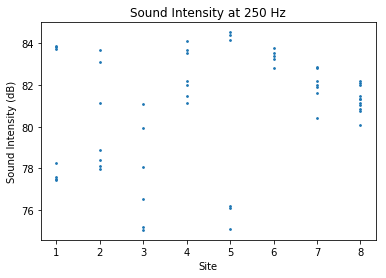

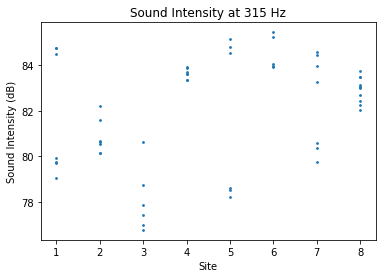

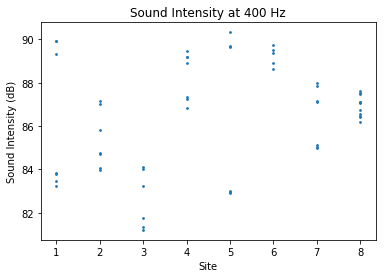

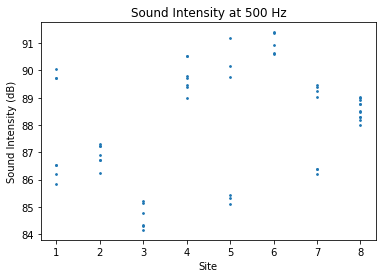

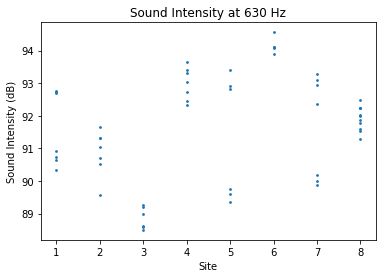

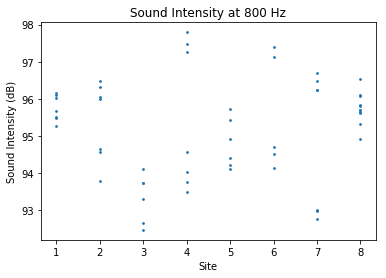

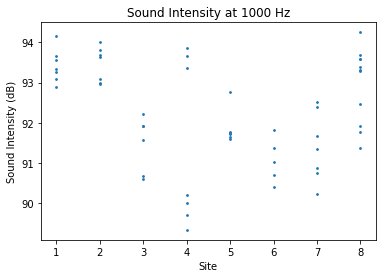

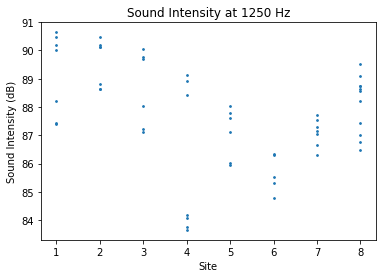

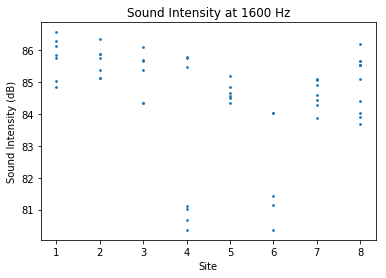

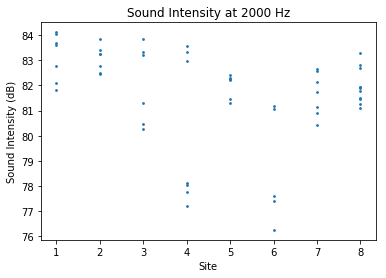

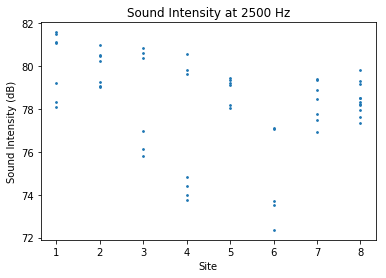

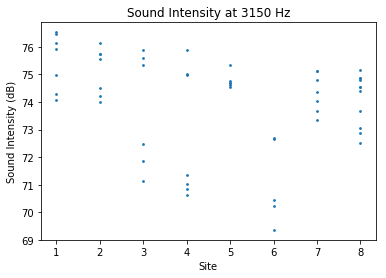

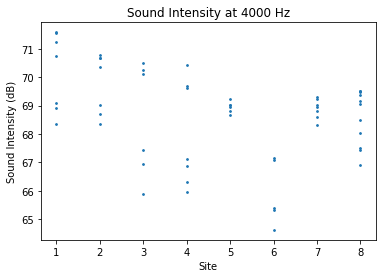

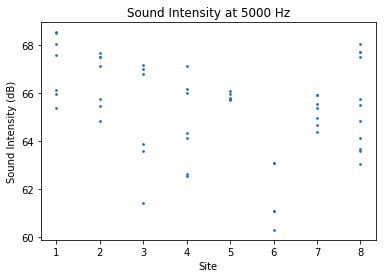

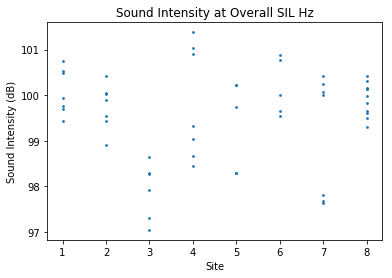

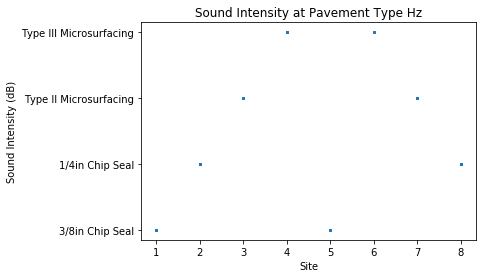

In [3]:
#Plot data by site and sound intensity. Each figure is a different frequency
for freq in OBSI.columns[3:]:
    plt.figure()
    plt.scatter(OBSI["Site"],OBSI[freq], s = 3)
    plt.title("Sound Intensity at " + str(freq) + " Hz")
    plt.xlabel("Site")
    plt.ylabel("Sound Intensity (dB)")
#     plt.ylim(58,105)

In [4]:
#Group data by year, site, pavement type, and replicates
OBSI_grouped = OBSI.set_index(["Measurement Year", "Site", "Pavement Type","Replicates"])
OBSI_grouped= OBSI_grouped.swaplevel("Pavement Type", "Site") #Use this to swap levels
OBSI_grouped.sort_index(inplace=True)
OBSI_grouped = OBSI_grouped.astype(float)

250  \
Measurement Year Pavement Type           Site Replicates              
0                1/4in Chip Seal         2    1           78.134415   
                                              2           78.871586   
                                              3           77.950447   
                                              4           78.402812   
                                         8    1           82.175721   
                                              2           80.747433   
                                              3           81.462971   
                                              4           81.133165   
                 3/8in Chip Seal         1    1           78.272962   
                                              2           77.424128   
                                              3           77.503556   
                                              4           77.594450   
                                         5    1           76.206128   
                                              2           75.079422   
                                              3           76.107714   
                 Type II Microsurfacing  3    1           75.047623   
                                              2           75.163727   
                                              3           76.544013   
                                         7    1           82.795095   
                                              2           81.888315   
                                              3           82.849268   
                                              4           82.168847   
                 Type III Microsurfacing 4    1           81.132513   
                                              2           82.189725   
                                              3           81.479575   
                                         6    2           83.534950   
                                              3           83.777596   
1                1/4in Chip Seal         2    1           81.153424   
                                              2           83.658388   
                                              3           83.119201   
                                         8    1           81.329238   
                                              2           81.329238   
                                              3           81.983753   
                                              4           80.067849   
                                              5           81.026652   
                                              6           82.113862   
                                              7           80.849675   
                 3/8in Chip Seal         1    1           83.887058   
                                              2           83.705899   
                                              3           83.810148   
                                         5    1           84.528425   
                                              2           84.391510   
                                              3           84.149466   
                 Type II Microsurfacing  3    1           81.076390   
                                              2           79.934984   
                                              3           78.077423   
                                         7    1           80.430940   
                                              2           81.993012   
                                              3           81.605286   
                 Type III Microsurfacing 4    1           82.016674   
                                              2           83.525260   
                                              3           84.129592   
                                              4           83.678356   
                                         6    1           83.231293   
                                              2           83.415562   
                 

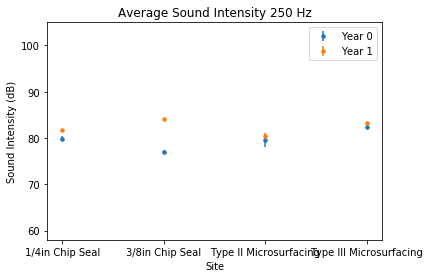

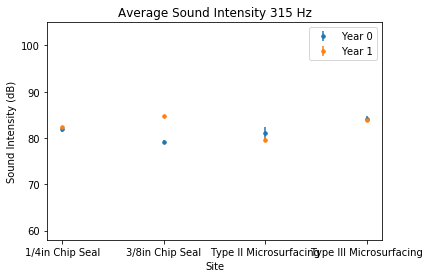

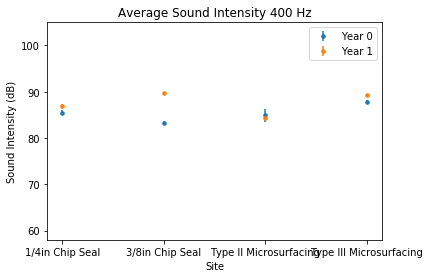

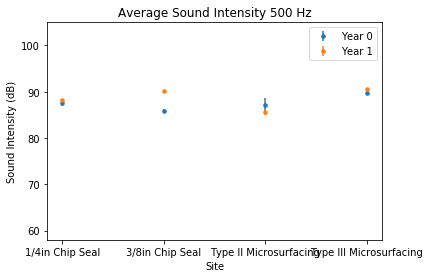

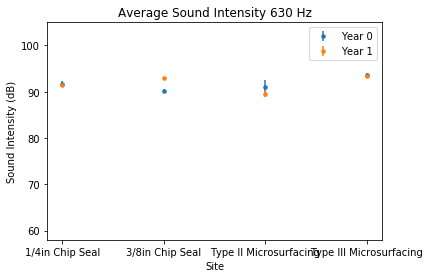

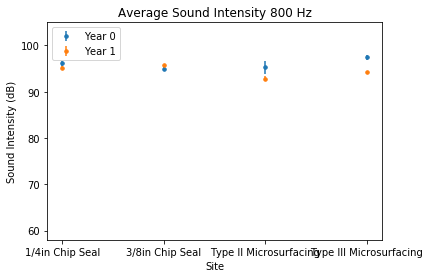

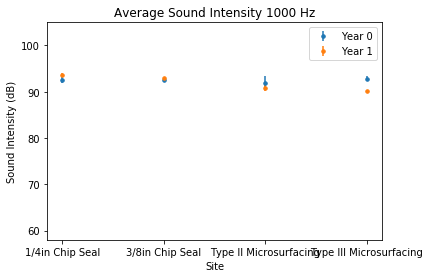

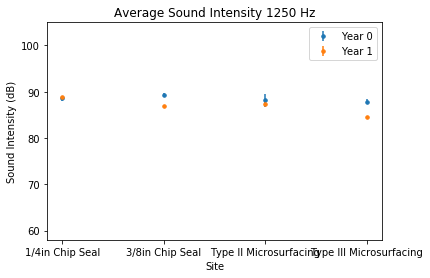

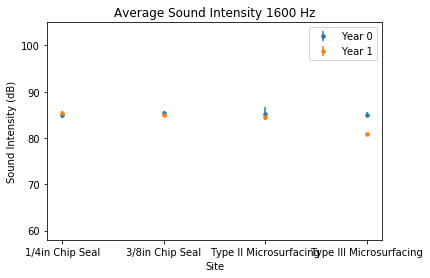

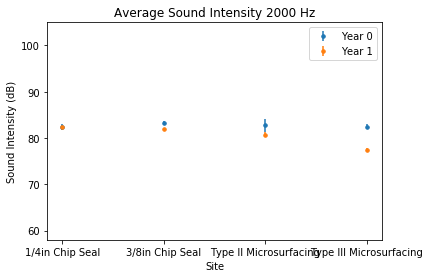

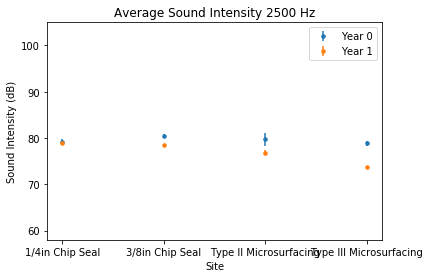

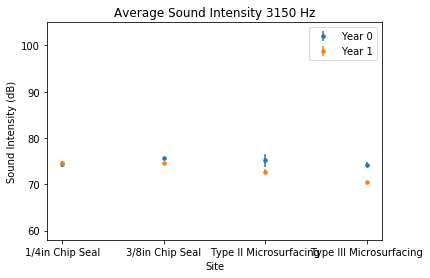

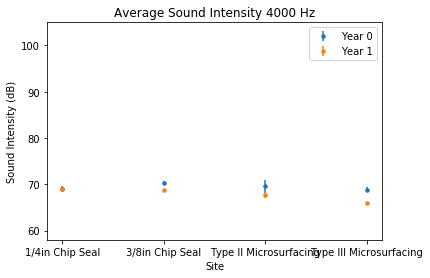

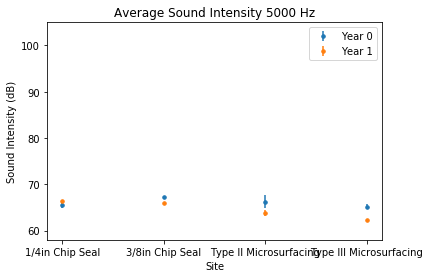

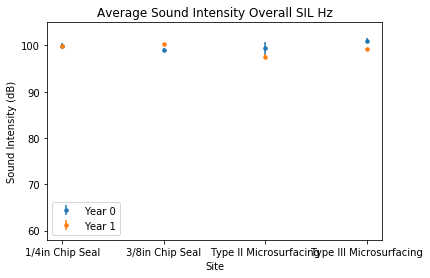

In [9]:
#Mean grouped by year and site
OBSI_mean_by_site = OBSI_grouped.groupby(level = [0,1]).mean()
OBSI_yearly_sem = OBSI_grouped.groupby(level = [0,1]).sem()
#Plot data by site and sound intensity averaged and separated by year
for freq in OBSI_mean_by_site.columns:
    plt.figure()
    plt.errorbar(OBSI_mean_by_site.loc[0].index,OBSI_mean_by_site.loc[0][freq], 
                OBSI_yearly_sem.loc[0][250], ls = "None",marker = ".", ms= 7, label = "Year 0")
    plt.errorbar(OBSI_mean_by_site.loc[1].index,OBSI_mean_by_site.loc[1][freq],
                OBSI_yearly_sem.loc[1][250], ls = "None",marker = ".", ms = 7, label = "Year 1")
    plt.legend()
    plt.xlabel("Site")
    plt.ylabel("Sound Intensity (dB)")
    plt.ylim(58,105)
    plt.title("Average Sound Intensity "+ str(freq) + " Hz")

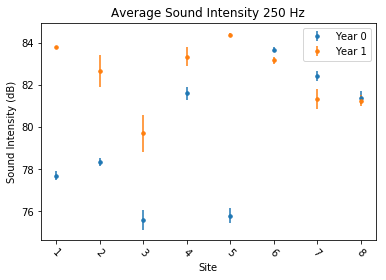

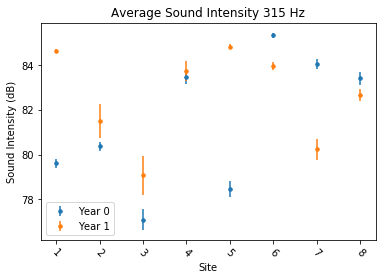

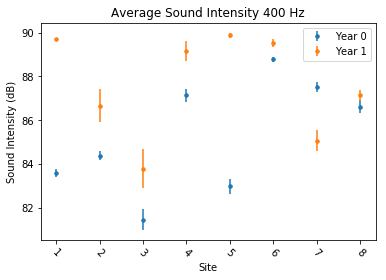

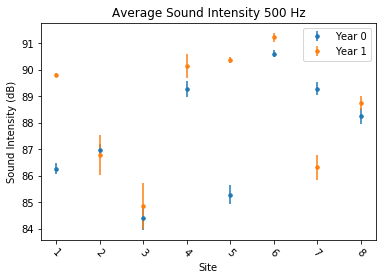

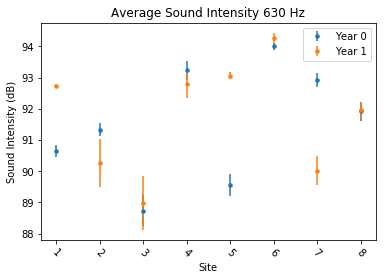

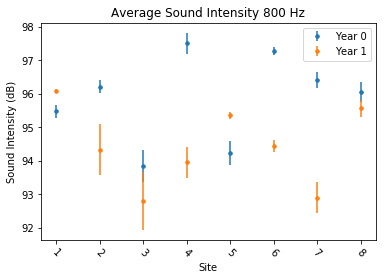

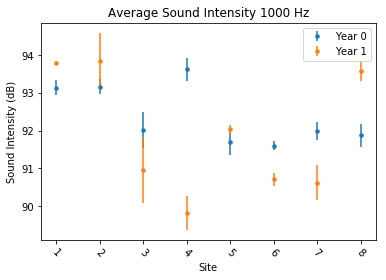

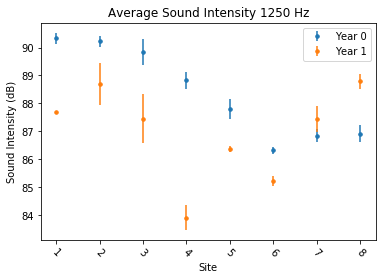

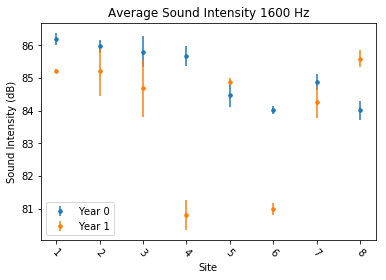

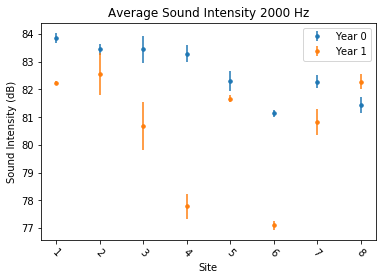

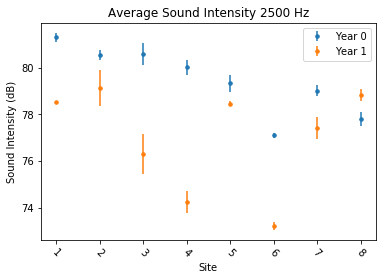

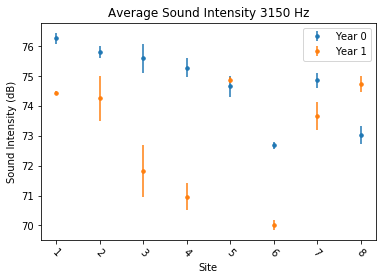

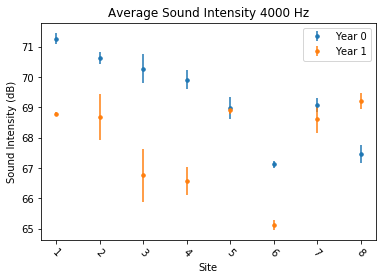

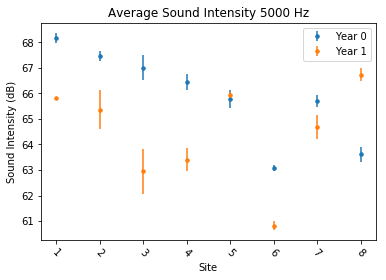

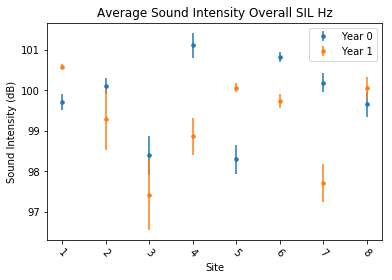

In [79]:
#Mean grouped by year and pavement type
OBSI_mean_by_pavement = OBSI_grouped.groupby(level = [0,2]).mean()
OBSI_sem_by_pavement = OBSI_grouped.groupby(level = [0,2]).sem()

#PLOT
for freq in OBSI_mean_by_pavement.columns:
    plt.figure()
    plt.errorbar(OBSI_mean_by_pavement.loc[0].index,OBSI_mean_by_pavement.loc[0][freq], 
                OBSI_sem_by_pavement.loc[0][250], ls = "None",marker = ".", ms= 7, label = "Year 0")
    plt.errorbar(OBSI_mean_by_pavement.loc[1].index,OBSI_mean_by_pavement.loc[1][freq],
                OBSI_sem_by_pavement.loc[1][250], ls = "None",marker = ".", ms = 7, label = "Year 1")
    plt.legend()
    plt.xlabel("Site")
    plt.ylabel("Sound Intensity (dB)")
    plt.xticks(rotation=-45)
#     plt.ylim(58,105)
    plt.title("Average Sound Intensity "+ str(freq) + " Hz")

In [12]:
#Count how many datapoints are in each grouping
OBSI_counts_by_site =OBSI_grouped.groupby(level = [0,1]).count()
OBSI_counts_by_pavement =OBSI_grouped.groupby(level = [0,2]).count()
OBSI_counts_by_pavement, OBSI_counts_by_site

(                       250  315  400  500  630  800  1000  1250  1600  2000  \
 Measurement Year Site                                                         
 0                1       4    4    4    4    4    4     4     4     4     4   
                  2       4    4    4    4    4    4     4     4     4     4   
                  3       3    3    3    3    3    3     3     3     3     3   
                  4       3    3    3    3    3    3     3     3     3     3   
                  5       3    3    3    3    3    3     3     3     3     3   
                  6       2    2    2    2    2    2     2     2     2     2   
                  7       4    4    4    4    4    4     4     4     4     4   
                  8       4    4    4    4    4    4     4     4     4     4   
 1                1       3    3    3    3    3    3     3     3     3     3   
                  2       3    3    3    3    3    3     3     3     3     3   
                  3       3    3    3   

In [180]:
#Transform data to look at all frequences for each site
#Group data by site, year, and pavement type
OBSIfreq = OBSI_grouped.T

# OBSIfreq_mean_type = OBSIfreq[:14].groupby(level = [1],axis = 1).mean()
OBSIfreq_mean_site = OBSIfreq[:14].groupby(level = [2],axis = 1).mean()
OBSIfreq_mean_yr_type = OBSIfreq[:14].groupby(level = [0,1],axis = 1).mean()
OBSIfreq_mean_yr_site = OBSIfreq[:14].groupby(level = [0,2],axis = 1).mean()

# OBSIfreq_sem_type = OBSIfreq[:14].groupby(level = [1],axis = 1).sem()
OBSIfreq_sem_site = OBSIfreq[:14].groupby(level = [2],axis = 1).sem()
OBSIfreq_sem_yr_type = OBSIfreq[:14].groupby(level = [0,1],axis = 1).sem()
OBSIfreq_sem_yr_site = OBSIfreq[:14].groupby(level = [0,2],axis = 1).sem()

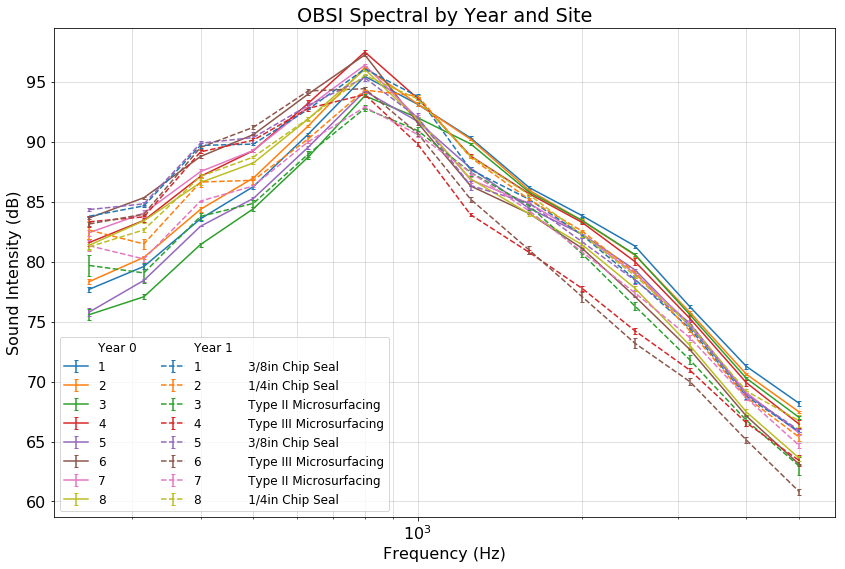

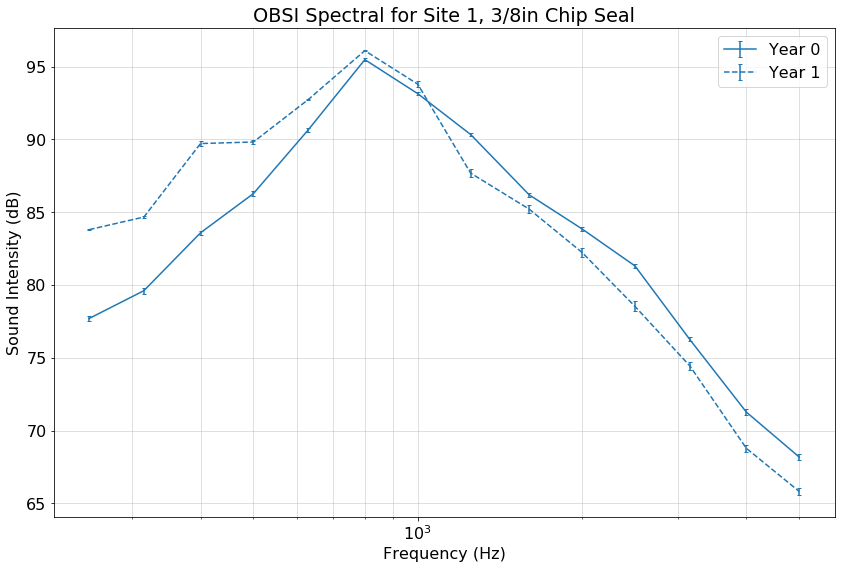

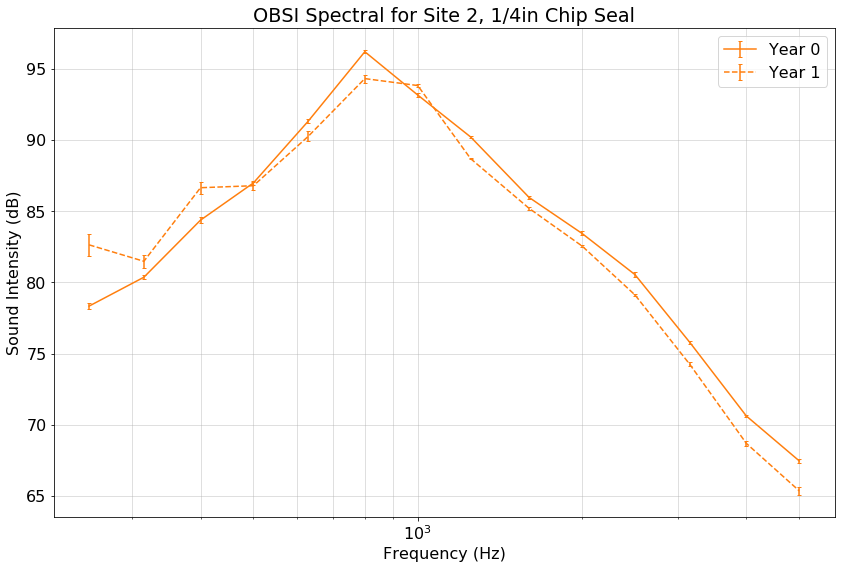

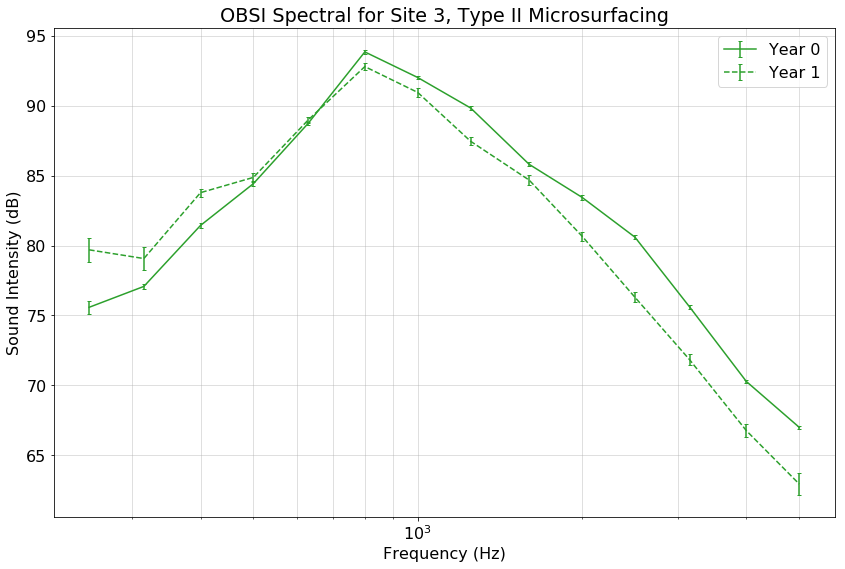

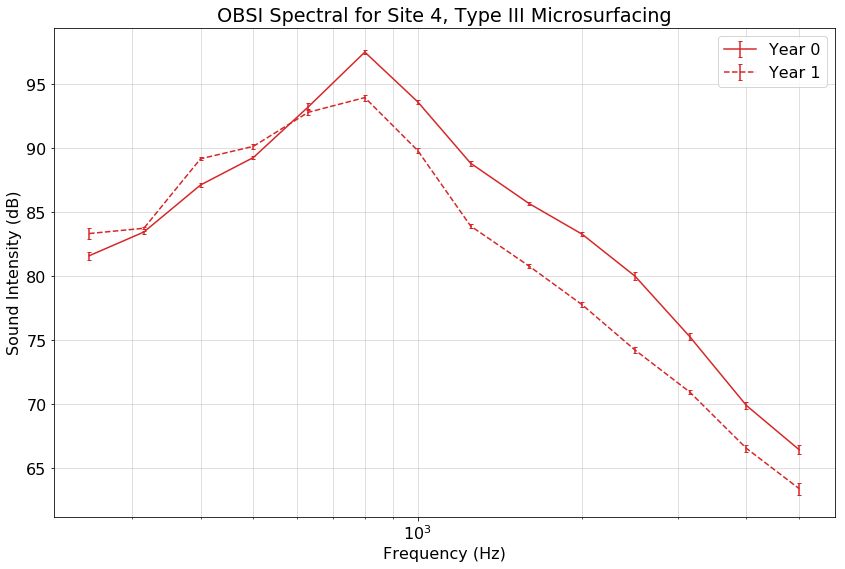

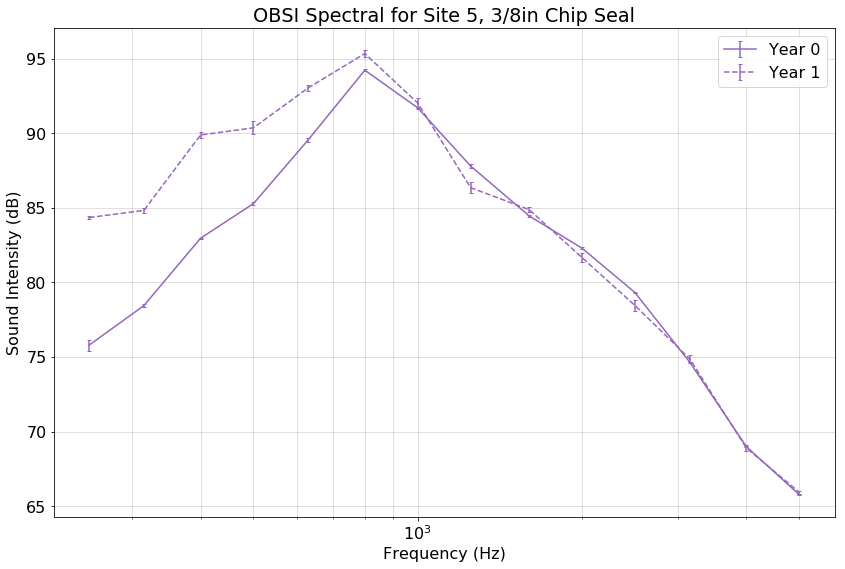

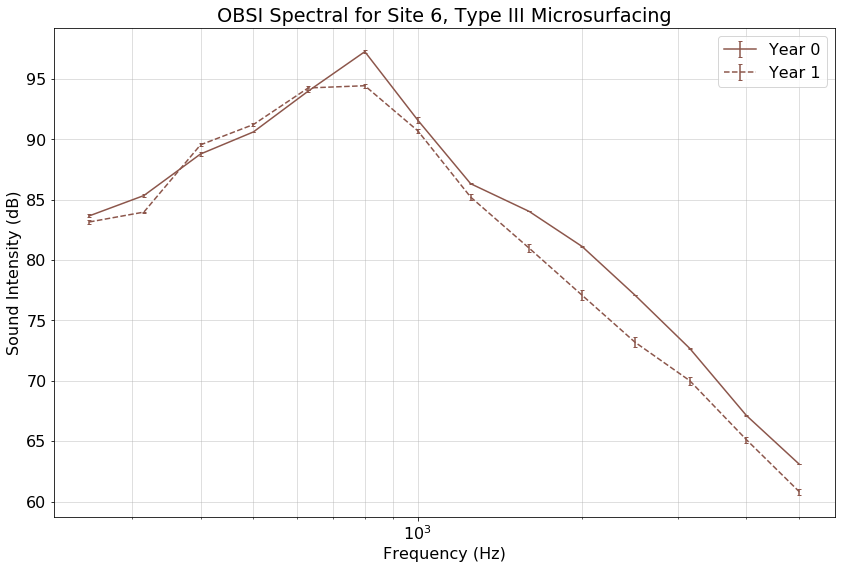

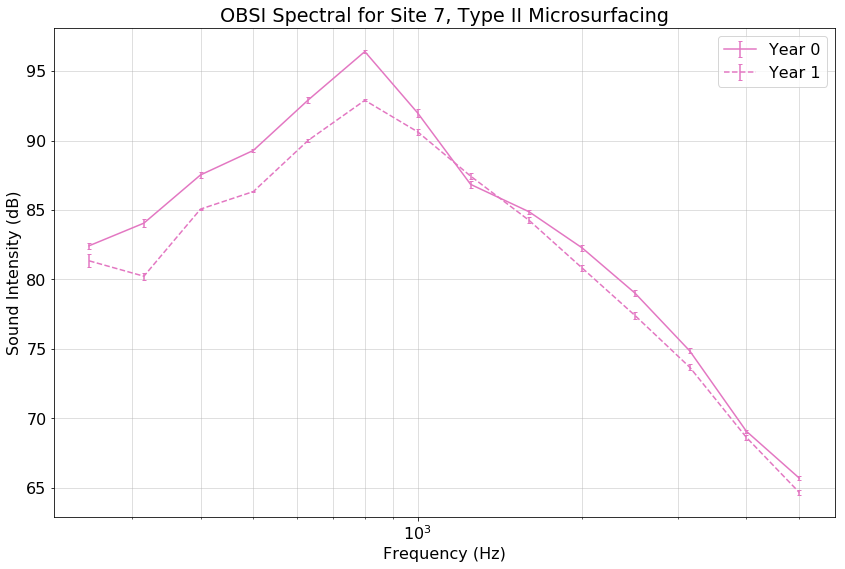

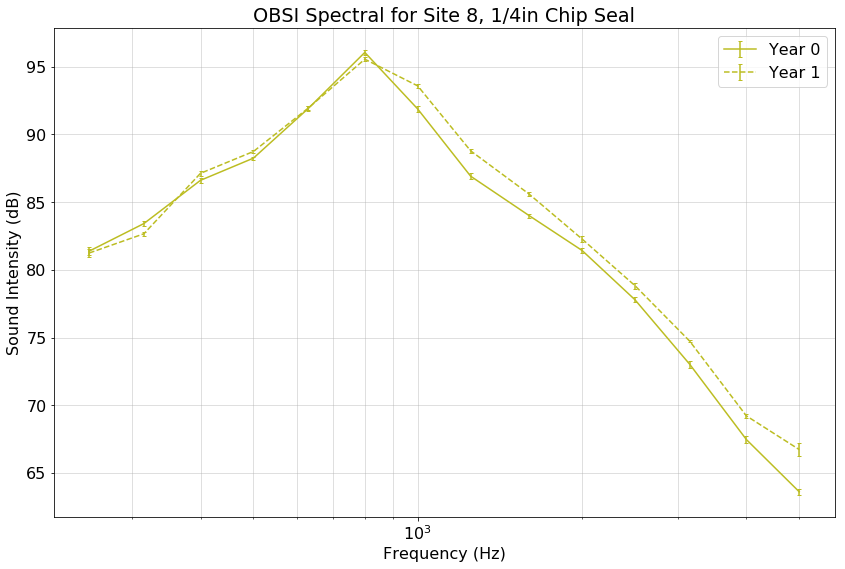

In [179]:
plt.figure(figsize = (14,9))
plt.rcParams.update({"font.size":16})
plt.rc("axes", prop_cycle=(cycler('color',['#1f77b4','#ff7f0e','#2ca02c','#d62728',
                                          '#9467bd','#8c564b','#e377c2', '#bcbd22'])))

for yr in [0,1]:
    for site in range(1,9):
        if yr == 0:
            plt.errorbar(OBSIfreq_mean_yr_site.index, OBSIfreq_mean_yr_site[yr][site],OBSIfreq_sem_yr_site[yr][site],
                    capsize = 2, linestyle = "-")
        else:
            plt.errorbar(OBSIfreq_mean_yr_site.index, OBSIfreq_mean_yr_site[yr][site],OBSIfreq_sem_yr_site[yr][site],
                    capsize = 2, linestyle = "--", label = str(site) + "             "+pavement_type[site])
            
h, l = plt.gca().get_legend_handles_labels()
ph = [plt.plot([], marker = "", ls = "")[0]]
handles = ph + h[0:int(len(h)/2)]+ ph+ h[int(len(h)/2):]
labels = ["Year 0"]+l[0:int(len(h)/2)]+["Year 1"]+l[int(len(h)/2):]

plt.grid(which = "both", alpha = 0.5)
plt.legend(handles, labels,  prop={'size': 12}, ncol = 2)
plt.grid(which = "both", alpha = 0.5)
plt.title("OBSI Spectral by Year and Site")
plt.xscale("log")
plt.ylabel("Sound Intensity (dB)")
plt.xlabel("Frequency (Hz)")

#Site Comparisons
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2', '#bcbd22']
for site, col in zip(range(1,9), colors):
    plt.figure(figsize = (14,9))
    for yr in [0,1]:
        if yr == 0:
            plt.errorbar(OBSIfreq_mean_yr_site.index, OBSIfreq_mean_yr_site[yr][site],OBSIfreq_sem_yr_site[yr][site],
                    capsize = 2, linestyle = "-", label = "Year 0", color = col)
        else:
            plt.errorbar(OBSIfreq_mean_yr_site.index, OBSIfreq_mean_yr_site[yr][site],OBSIfreq_sem_yr_site[yr][site],
                    capsize = 2, linestyle = "--", label = "Year 1", color = col)

    plt.legend()
    plt.grid(which = "both", alpha = 0.5)
    plt.title("OBSI Spectral for Site " + str(site) + ", " +pavement_type[site])
    plt.xscale("log")
    plt.ylabel("Sound Intensity (dB)")
    plt.xlabel("Frequency (Hz)")

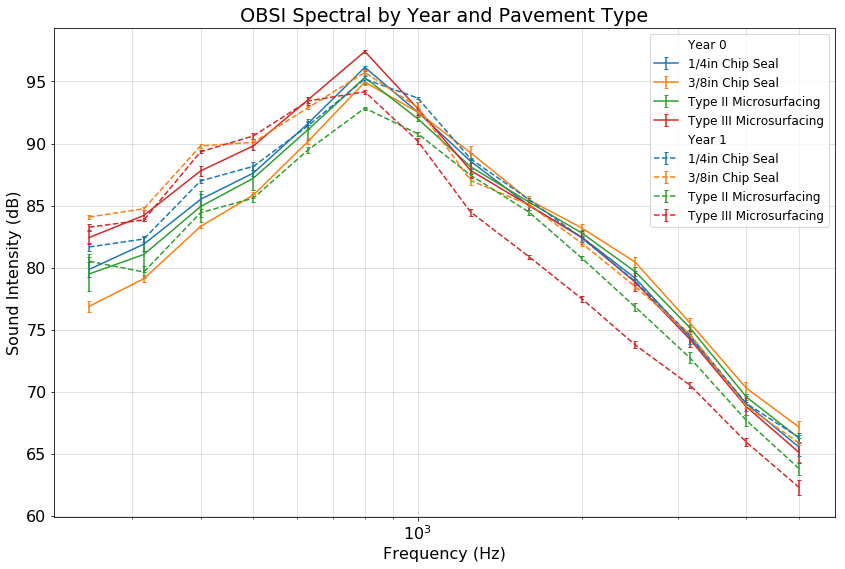

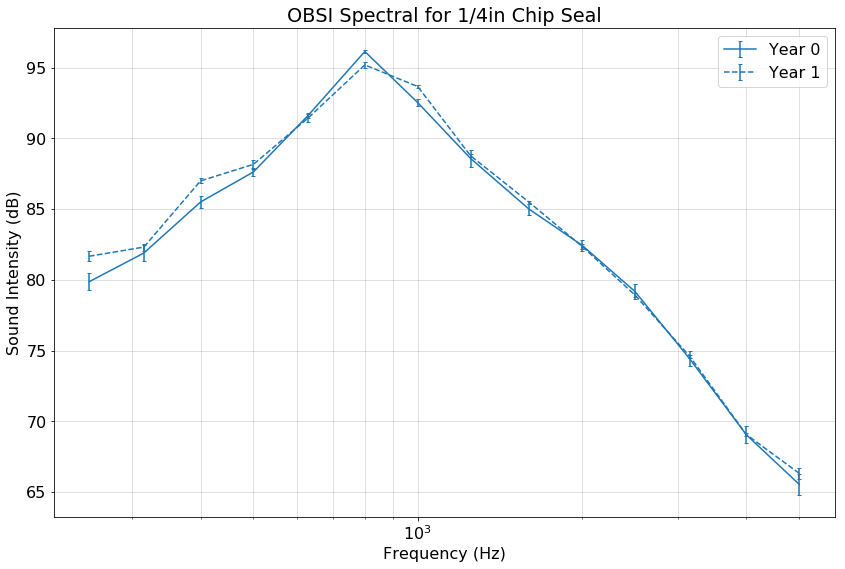

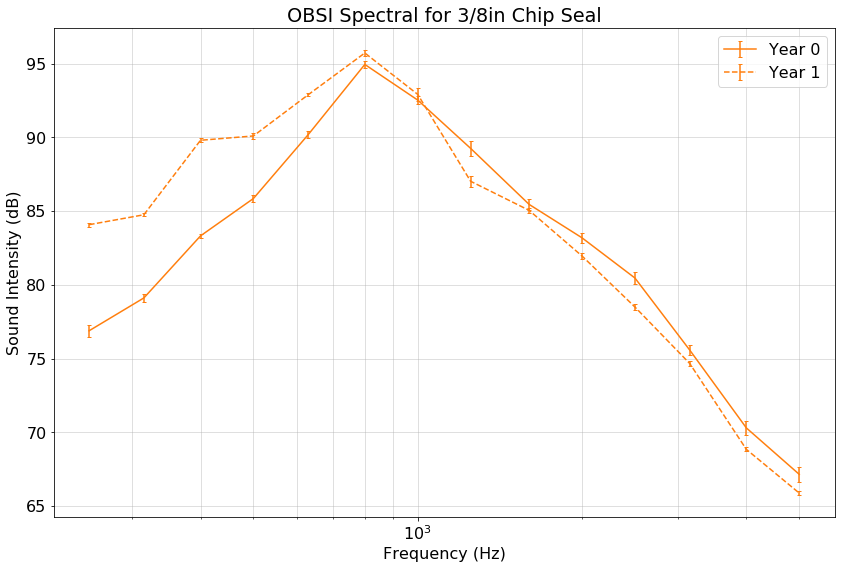

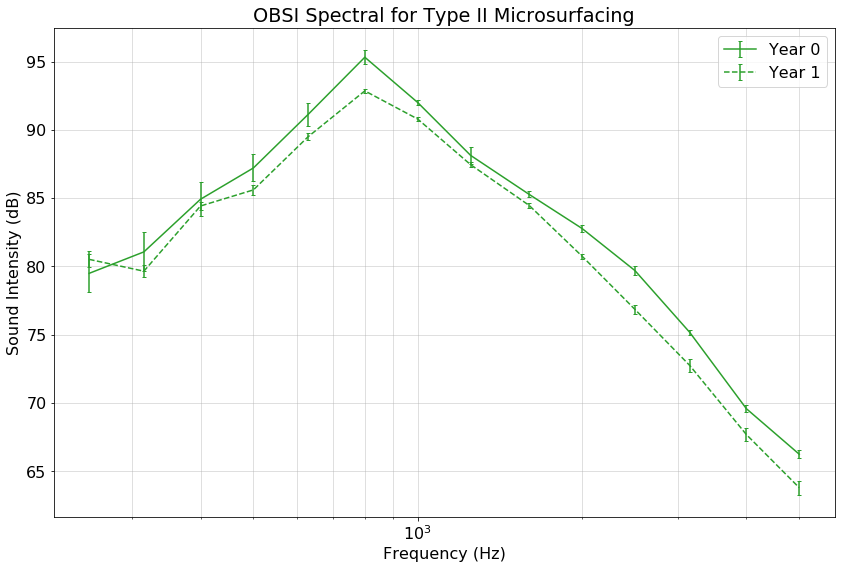

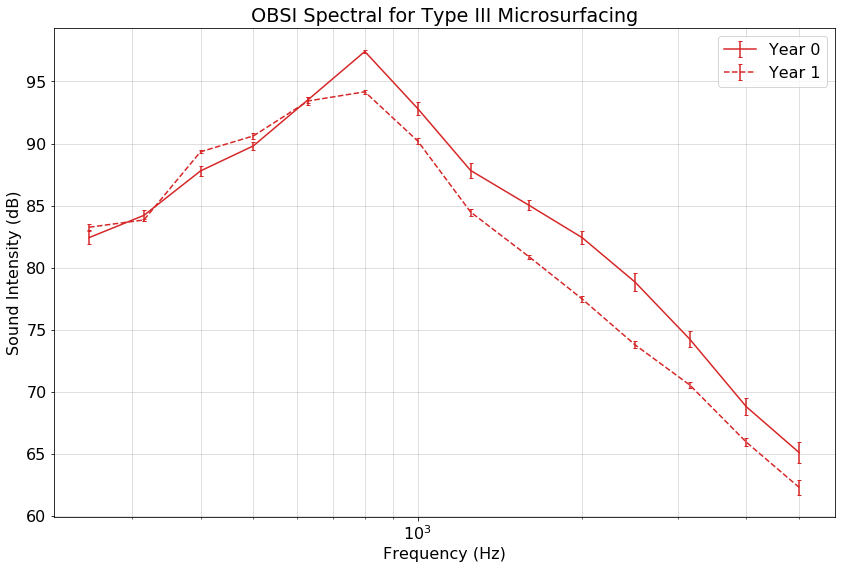

In [143]:
#Figures for Year and Pavement Type Grouping
plt.figure(figsize = (14,9))
plt.rcParams.update({'font.size': 16})
plt.rc("axes", prop_cycle=(cycler('color',['#1f77b4','#ff7f0e','#2ca02c','#d62728'])))
for yr in [0,1]:
    for ptype in OBSIfreq_mean_yr_type.columns.levels[1]:
        if yr == 0:
            plt.errorbar(OBSIfreq_mean_yr_type.index, OBSIfreq_mean_yr_type[yr][ptype],OBSIfreq_sem_yr_type[yr][ptype],
                    capsize = 2)
        else:
            plt.errorbar(OBSIfreq_mean_yr_type.index, OBSIfreq_mean_yr_type[yr][ptype],OBSIfreq_sem_yr_type[yr][ptype],
                    capsize = 2, linestyle = "--")

h, l = plt.gca().get_legend_handles_labels()
ph = [plt.plot([], marker = "", ls = "")[0]]
handles = ph + h[0:int(len(h)/2)]+ ph+ h[int(len(h)/2):]
labels = ["Year 0"]+l[0:int(len(h)/2)]+["Year 1"]+l[int(len(h)/2):]
plt.grid(which = "both", alpha = 0.5)
plt.legend(handles, labels,  prop={'size': 12})
plt.grid(which = "both", alpha = 0.5)
plt.title("OBSI Spectral by Year and Pavement Type")
plt.xscale("log")
plt.ylabel("Sound Intensity (dB)")
plt.xlabel("Frequency (Hz)")

#Site comparisons
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728']
for ptype, col in zip(OBSIfreq_mean_yr_type.columns.levels[1], colors):
    plt.figure(figsize = (14,9))
    for yr in [0,1]:
        if yr == 0:
            plt.errorbar(OBSIfreq_mean_yr_type.index, OBSIfreq_mean_yr_type[yr][ptype],OBSIfreq_sem_yr_type[yr][ptype],
                    capsize = 2, color = col, label = "Year 0")
        else:
            plt.errorbar(OBSIfreq_mean_yr_type.index, OBSIfreq_mean_yr_type[yr][ptype],OBSIfreq_sem_yr_type[yr][ptype],
                    capsize = 2, linestyle = "--", color = col, label = "Year 1")
    plt.grid(which = "both", alpha = 0.5)
    plt.legend()
    plt.title("OBSI Spectral for " + ptype)
    plt.xscale("log")
    plt.ylabel("Sound Intensity (dB)")
    plt.xlabel("Frequency (Hz)")    

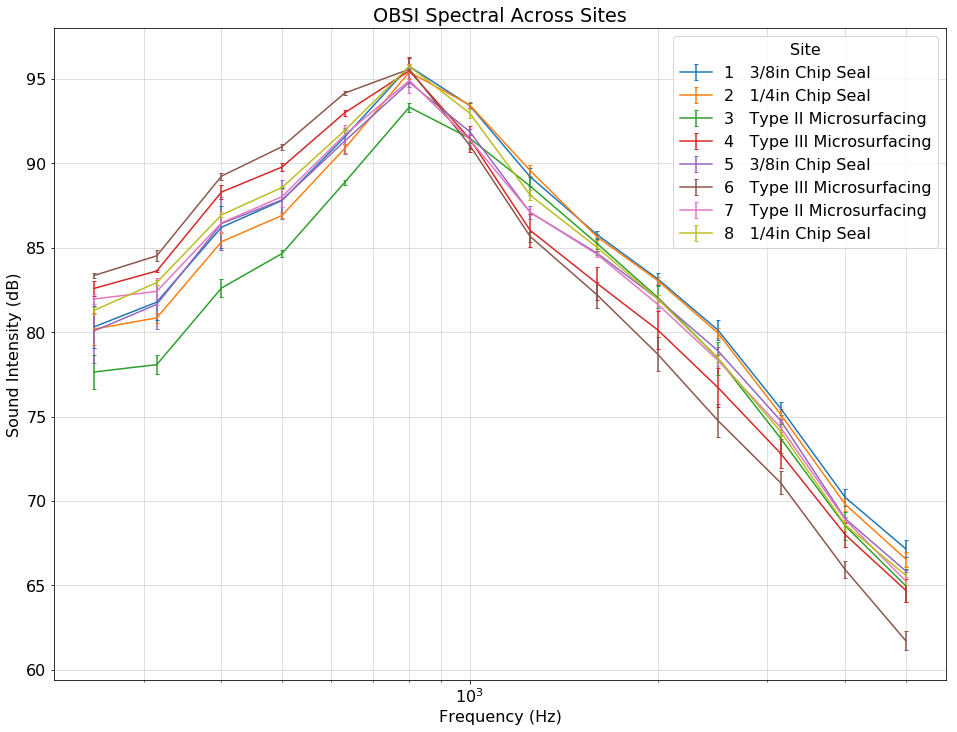

In [369]:
#Figures for site grouping
plt.figure(figsize = (16,12))
plt.rcParams.update({'font.size': 16})
for site in OBSIfreq_mean_site.columns:
    plt.errorbar(OBSIfreq_mean_site.index, OBSIfreq_mean_site[site], OBSIfreq_sem_site[site],
                capsize = 2, label = str(site) + "   "+pavement_type[site])
plt.xscale("log")
plt.grid(which = "both", alpha = 0.5)
plt.title("OBSI Spectral Across Sites")
plt.ylabel("Sound Intensity (dB)")
plt.xlabel("Frequency (Hz)")
plt.legend(title = "Site")

ALL PASSBY DATA

In [ ]:
#All passby data as a dataframe with a single header that are tuples
allpassby_single_header = pd.read_excel("C:\\Quiet_Pavement_Local\\Data Summary QP Re-Analysis.xlsx", sheet_name="All Passby", header =0)
allpassby.columns_single_header = [(first,second) for first, second in zip(allpassby.iloc[0],allpassby.iloc[1])]

In [375]:
#Processes allpassby data, turns two row header into one row header as a tuple
allpassby = pd.read_excel("C:\\Quiet_Pavement_Local\\Data Summary QP Re-Analysis.xlsx", sheet_name="All Passby", header =0)
allpassby.dropna(axis = 0, how = "all",inplace = True)
allpassby.dropna(axis = 1, how = "all", inplace = True)
allpassby.set_index(["Unnamed: 2"], inplace = True)

#Drop Meas Year, date, passtime, halfstep, vehtype, clean, Comment, winddir,
# cloud, ParkName, SiteName (the second one), and IntTemp
#These columns are either irrelevant, only exist for site 07, or are empty
allpassby.drop(["Unnamed: 0","Unnamed: 1","Unnamed: 3","Unnamed: 4","Unnamed: 5","Unnamed: 6",
                "Unnamed: 8","Unnamed: 12","Unnamed: 13","Unnamed: 15","Unnamed: 16", "Unnamed: 22"], axis = 1, inplace = True)

#Drop accidentally copy/pasted frequency data
droplist = []
for i in range(97,133):
    droplist.append("Unnamed: "+str(i))
allpassby.drop(droplist, axis = 1, inplace = True)

#Create multilevel columns
header_corrections = []
for a,b in zip(allpassby.loc["sitename"].values.tolist(), allpassby.columns.tolist()):
    if isinstance(a,float):
        if "1/3 LZFeq" in b:
            header_corrections.append("1/3 LZFeq")
        else:
            header_corrections.append("1/3 LZFmax")
    else:
        header_corrections.append(a)
allpassby.columns = [header_corrections, allpassby.loc["sitename"].values.tolist()]
allpassby.drop(["sitename"],axis = 0, inplace = True)

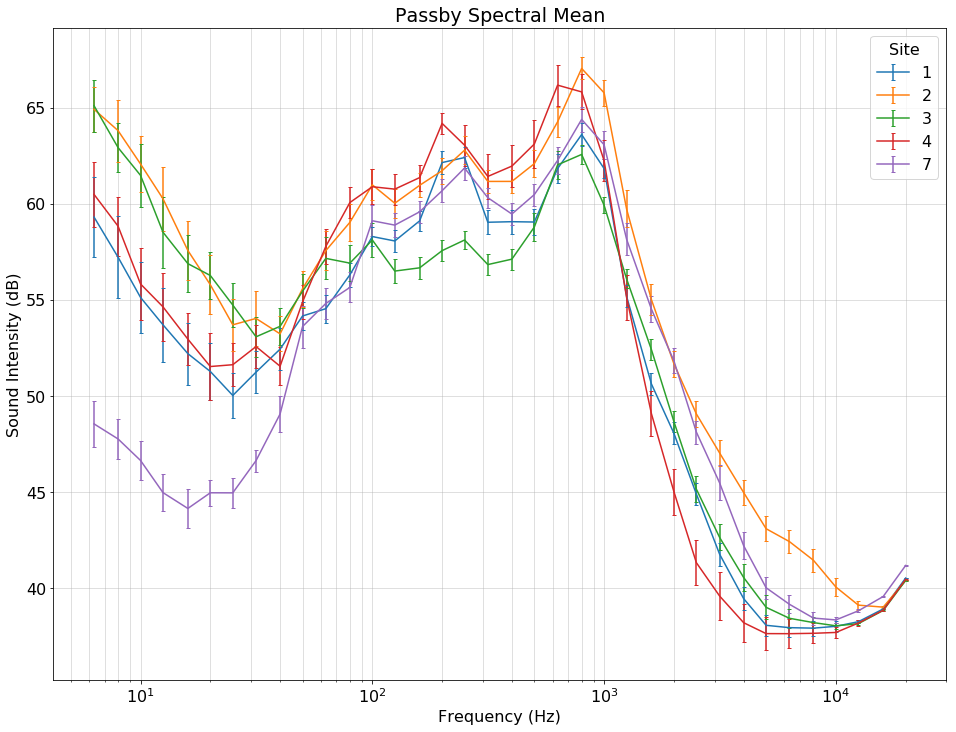

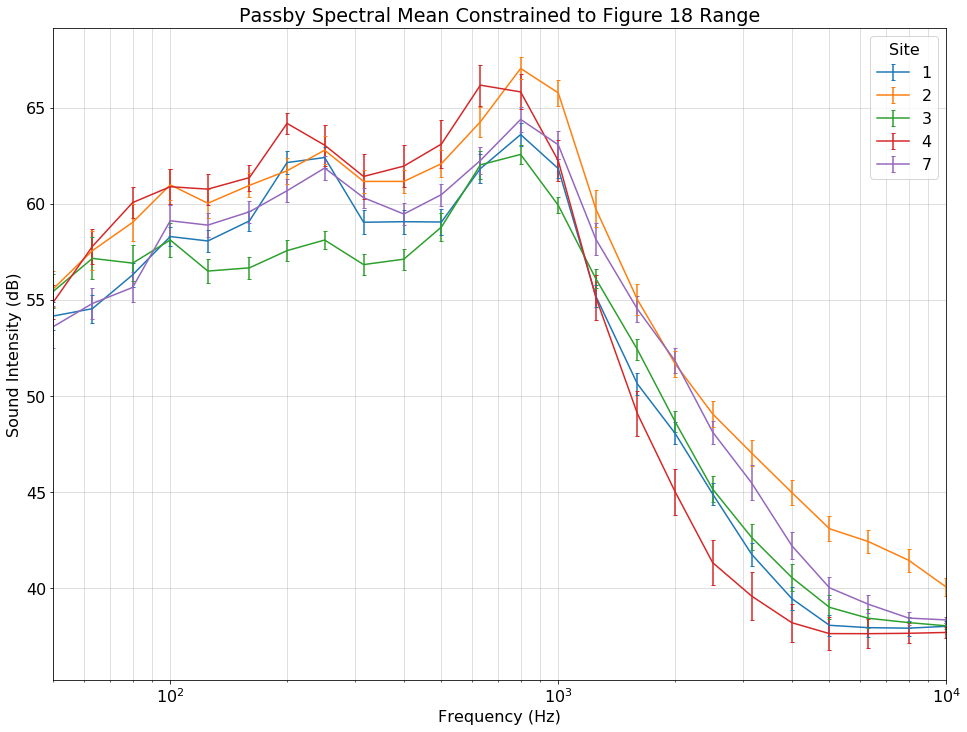

In [391]:
#Mean sound intensity figures across all sites
sites = [1,2,3,4,7]

plt.figure(figsize = (16,12))
for site in sites:
    mean=allpassby["1/3 LZFeq"].loc["S0" + str(site)].mean()
    sem = allpassby["1/3 LZFeq"].loc["S0" + str(site)].sem()
    plt.errorbar(mean.axes[0], mean.values, sem.values, label = site, capsize = 2)
    plt.xscale("log")
    
plt.grid(which = "both", alpha = 0.5)
plt.title("Passby Spectral Mean")
plt.ylabel("Sound Intensity (dB)")
plt.xlabel("Frequency (Hz)")
plt.legend(title = "Site")

#Mean sound intensity figures, x axis constrained to figure 18 range
plt.figure(figsize = (16,12))
for site in sites:
    mean=allpassby["1/3 LZFeq"].loc["S0" + str(site)].mean()
    sem = allpassby["1/3 LZFeq"].loc["S0" + str(site)].sem()
    plt.errorbar(mean.axes[0], mean.values, sem.values, label = site, capsize = 2)
    plt.xscale("log")
plt.xlim(50,10000)  
plt.grid(which = "both", alpha = 0.5)
plt.title("Passby Spectral Mean Constrained to Figure 18 Range")
plt.ylabel("Sound Intensity (dB)")
plt.xlabel("Frequency (Hz)")
plt.legend(title = "Site")

In [392]:
allpassby

speed airTemp   RH windspeed pavetemp LAFeq LASmax LAFmax LZFeq  \
           speed airTemp   RH windspeed pavetemp LAFeq LASmax LAFmax LZFeq   
Unnamed: 2                                                                   
S07           39      90   18      calm      100  63.2   61.4   63.9  69.8   
S07           45      86   25      calm       91  68.2   66.9   69.1  74.5   
S07           45      90   18      calm      100  70.1     68   70.8  73.6   
S07           46      80   26      calm       81    68   66.2   69.3  72.7   
S07           46      80   26      calm       81  66.9   65.2   68.3    71   
S07           46      86   25      calm       91    67     65   68.7  71.2   
S07           46      91   18      calm       94  68.4   66.5   69.9  72.8   
S07           47      80   26      calm       81  69.1   67.3     70  73.1   
S07           47      90   18      calm      100  69.6   68.1     70  74.2   
S07           47      91   18      calm       94  67.3   65.6   68.7    75   
S07           48      90   18      calm      100  65.6   63.8   67.8  73.3   
S07           48      90   18      calm      100  69.2   67.3   70.4    73   
S07           49      90   18      calm      100  69.7   67.6   70.2    74   
S07           50      86   25      calm       91  72.4   70.4   73.3    76   
S07           50      90   18      calm      100  71.3   69.1   72.2  75.1   
S07           51      86   25      calm       91  70.8   68.9   71.4  74.5   
S07           51      90   18      calm      100  69.9   68.1   70.6  74.2   
S07           52      80   26      calm       81  70.5   68.7   71.5  74.4   
S07           55      90   18      calm      100  66.1   64.6   66.9    70   
S07           56      86   25      calm       91  71.5   69.6   71.8  75.2   
S07           57      80   29      calm       76  73.4   71.6   73.8  77.4   
S07           57      86   25      calm       91  74.5   72.4   75.4  78.7   
S07           60      80   29      calm       76  72.6   70.1   73.6  80.6   
S07           60      86   25      calm       91    75   73.1   75.5  81.7   
S07           60      90   18      calm      100  73.6   71.4   74.2  76.5   
S07           61      90   18      calm      100  70.7   68.8   71.9  74.3   
S01           43     NaN  NaN       NaN      NaN   NaN    NaN   70.2   NaN   
S01           47     NaN  NaN       NaN      NaN   NaN    NaN   67.9   NaN   
S01           35     NaN  NaN       NaN      NaN   NaN    NaN   62.6   NaN   
S01           40     NaN  NaN       NaN      NaN   NaN    NaN   67.6   NaN   
...          ...     ...  ...       ...      ...   ...    ...    ...   ...   
S03           47     NaN  NaN       NaN      NaN   NaN    NaN   69.4   NaN   
S03           44     NaN  NaN       NaN      NaN   NaN    NaN   69.7   NaN   
S03           46     NaN  NaN       NaN      NaN   NaN    NaN     70   NaN   
S03           49     NaN  NaN       NaN      NaN   NaN    NaN   69.8   NaN   
S03           42     NaN  NaN       NaN      NaN   NaN    NaN   67.6   NaN   
S03           47     NaN  NaN       NaN      NaN   NaN    NaN   65.7   NaN   
S03           54     NaN  NaN       NaN      NaN   NaN    NaN   69.4   NaN   
S03           54     NaN  NaN       NaN      NaN   NaN    NaN   69.6   NaN   
S03           49     NaN  NaN       NaN      NaN   NaN    NaN   71.8   NaN   
S03           47     NaN  NaN       NaN      NaN   NaN    NaN   67.4   NaN   
S03           41     NaN  NaN       NaN      NaN   NaN    NaN   65.3   NaN   
S03           40     NaN  NaN       NaN      NaN   NaN    NaN   67.8   NaN   
S03           41     NaN  NaN       NaN      NaN   NaN    NaN   68.4   NaN   
S04           44     NaN  NaN       NaN      NaN   NaN    NaN   69.6   NaN   
S04           65     NaN  NaN       NaN      NaN   NaN    NaN   75.3   NaN   
S04           55     NaN  NaN       NaN      NaN   NaN    NaN   72.9   NaN   
S04           35     NaN  NaN       NaN      NaN   NaN    NaN   66.8   NaN   
S04           57     NaN  NaN    